## Data Cleaning

In [2]:
import matplotlib as plt
import pandas as pd
import numpy as np
import re
import seaborn as sns
%matplotlib inline

df = pd.read_csv('C:\\Users\\beri.e.ndifon\\Documents\\Everything Else\\Personal\\Thinkful\\CSV Datasets\\WELLCOME.csv', encoding='Latin-1')
df.head()

,PMID/PMCID,Publisher,Journal title,Article title,COST (£) charged to Wellcome (inc VAT when charged)
0,NaN,CUP,Psychological Medicine,Reduced parahippocampal cortical thickness in ...,£0.00
1,PMC3679557,ACS,Biomacromolecules,Structural characterization of a Model Gram-ne...,£2381.04
2,23043264 PMC3506128,ACS,J Med Chem,"Fumaroylamino-4,5-epoxymorphinans and related ...",£642.56
3,23438330 PMC3646402,ACS,J Med Chem,Orvinols with mixed kappa/mu opioid receptor a...,£669.64
4,23438216 PMC3601604,ACS,J Org Chem,Regioselective opening of myo-inositol orthoes...,£685.88


In [3]:
df.describe()

,PMID/PMCID,Publisher,Journal title,Article title,COST (£) charged to Wellcome (inc VAT when charged)
count,1928,2127,2126,2127,2127
unique,1880,299,984,2126,1402
top,Not yet available,Elsevier,PLoS One,"Exclusive breastfeeding, diarrhoel morbidity a...",£2040.00
freq,7,387,92,2,94


Based on count, there are 199 PMID/PMCIDs and 1 journal title missing. Because neither variable is imputable and the Readme file acknowledges that PMID/PMCIDs are only useful if I need to know whether an article is in PMC/Europe PMC (which isn't relevant to this analysis), I'm going to drop that entire column and later investigate if/why there's a discrepancy in actual/expected count for journal titles. The Readme file also acknowledges that in the absence of name authority controls, journals go by several aliases - I'm going to attempt to standardize those references as well. 

C:\Users\beri.e.ndifon\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


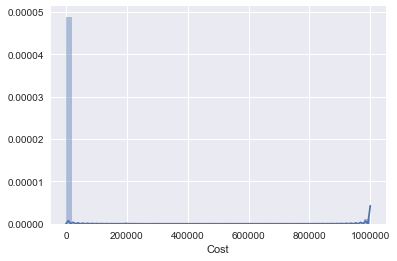

In [4]:
#Drops the PMID/PMCID column.
data = df.drop('PMID/PMCID',axis=1) 
#Renames columns for ease of reference.
data.rename(columns={'Journal title': 'Journal', 'Article title':'Article', 'COST (£) charged to Wellcome (inc VAT when charged)':'Cost'}, inplace=True) 
#Drops any NA values  in any of the columns.
data = data.dropna(subset=['Publisher','Journal','Article'])
#Removes all currency symbol occurrences. 
data.Cost = data.Cost.map(lambda x: x.lstrip('£$').rstrip('£$')) 

#Checks data type by series. 
data.dtypes
#Converts cost into a float: publisher, journal, and article are already strings.
data.Cost = data.Cost.map(lambda x: float(x))

#Removes all string columns leading/trailing whitespace.
data.Publisher = data.Publisher.map(lambda x: x.strip())
data.Journal = data.Journal.map(lambda x: x.strip())
data.Article = data.Article.map(lambda x: x.strip())

#Removes all non-alphanumeric, non-hyphen characters from all string columns.
data.Publisher = data.Publisher.str.extract("([a-zA-Z0-9:\(\)\+/&,\-]*)",expand=True)

#Converts string columns to all-capital case.
data.Publisher = data.Publisher.str.upper()
data.Journal = data.Journal.str.upper()
data.Article = data.Article.str.upper()

#Opted to forgo this part of the data cleaning sequence, given how time-consuming it would be.
#Wrote one instance out to illustrate how I intended to approached it.

#Sorts on publisher column.
#data.sort_values(by='Publisher',inplace=True)
#Lists journal titles that begin with each letter - in this instance, A. 
#data.Publisher.str.startswith('A')
#Makes replacements. 
#data.Publisher.str.replace('ACS (Amercian Chemical Society) Publications.*' , 'ACS')

#Opted to forgo this part of the data cleaning sequence, given how time-consuming it would be.
#Wrote one instance out to illustrate how I intended to approached it.

#Sorts on journal title column.
#data.sort_values(by='Journal',inplace=True)
#Lists journal titles that begin with each letter - in this instance, J. 
#data.Journal.str.startswith('J')
#Makes replacements. 
#data.Publisher.str.replace('Journal of Biol Chem.*' , 'Journal of Biological Chemistry')

#Checks the distribution of cost to determine plausibility and identify winsorization candidates.
sns.plt.show(sns.distplot(data.Cost))
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)
data.sort_values(by='Cost',inplace=True)

In [5]:
data.head()

,Publisher,Journal,Article,Cost
0,CUP,PSYCHOLOGICAL MEDICINE,REDUCED PARAHIPPOCAMPAL CORTICAL THICKNESS IN ...,0.00
243,BIOMED,VETERINARY RESEARCH,UNDERSTANDING FOOT-AND-MOUTH DISEASE VIRUS TRA...,9.93
100,AMERICAN,AMERICAN SOCIETY FOR NUTRITION,THE ASSOCIATION BETWEEN BREASTFEEDING AND HIV ...,45.94
1469,PUBLIC,PLOS ONE,HOW WELL ARE MALARIA MAPS USED TO DESIGN AND ...,122.31
1677,SCIEDU,JOURNAL OF BIOMEDICAL GRAPHICS AND COMPUTING,FUNCTIONAL MRI DEMONSTRATES PAIN PERCEPTION IN...,135.29


In [6]:
data.tail()

,Publisher,Journal,Article,Cost
1565,PUBLIC,PLOS ONE,PNEUMOCYSTIS JIROVECII PNEUMONIA IN TROPICAL A...,999999.0
560,ELSEVIER,EXPERIMENTAL CELL RESEARCH,PERTURBATION OF INVADOLYSIN DISRUPTS CELL MIGR...,999999.0
1939,WILEY,HBM JNL HUMAN BRAIN MAPPING,PHASE INFORMED MODEL FOR MOTION AND SUSCEPTIBI...,999999.0
996,MIT,THE JOURNAL OF COGNITIVE NEUROSCIENCE,PERCEPTUAL INTEGRATION FOR QUALITATIVELY DIFFE...,999999.0
1564,PUBLIC,PLOS ONE,PHAGOCYTOSIS IS THE MAIN CR3-MEDIATED FUNCTION...,999999.0


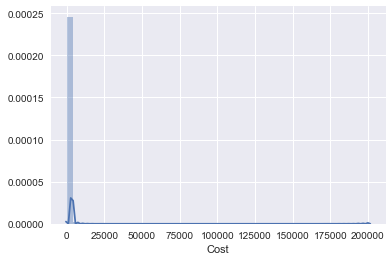

In [7]:
#Store in variables, don't hard-code. 
lower = data.Cost.quantile(0.05)
upper = data.Cost.quantile(0.95)
data.Cost.replace(to_replace=[0.00,999999.00], value=[lower, upper], inplace=True)
data.sort_values(by='Cost',inplace=True)
sns.plt.show(sns.distplot(data.Cost))

In [8]:
data.head()

,Publisher,Journal,Article,Cost
243,BIOMED,VETERINARY RESEARCH,UNDERSTANDING FOOT-AND-MOUTH DISEASE VIRUS TRA...,9.93
100,AMERICAN,AMERICAN SOCIETY FOR NUTRITION,THE ASSOCIATION BETWEEN BREASTFEEDING AND HIV ...,45.94
1469,PUBLIC,PLOS ONE,HOW WELL ARE MALARIA MAPS USED TO DESIGN AND ...,122.31
1677,SCIEDU,JOURNAL OF BIOMEDICAL GRAPHICS AND COMPUTING,FUNCTIONAL MRI DEMONSTRATES PAIN PERCEPTION IN...,135.29
975,LANDES,CHANNELS,STATE-INDEPENDENT INTRACELLULAR ACCESS OF QUAT...,159.74


In [9]:
#Might want to increase upper limit cut-off for winsorization. Didn't have to discard the free article.
data.tail()

,Publisher,Journal,Article,Cost
798,ELSEVIER,THE LANCET,EFFECTS OF UNCONDITIONAL AND CONDITIONAL CASH ...,4800.0
800,ELSEVIER,THE LANCET NEUROLOGY,GENETIC RISK FACTORS FOR ISCHAEMIC STROKE AND ...,5760.0
1619,PUBLIC,PUBLIC SERVICE REVIEW,LABORATORY SCIENCE IN TROPICAL MEDICINE,6000.0
1470,PUBLIC,PLOS ONE,REDUCING STOCK-OUTS OF LIFE SAVING MALARIA COM...,192645.0
1987,WILEY,MOVEMENT DISORDERS,LIMB AMPUTATIONS IN FIXED DYSTONIA: A FORM OF ...,201024.0


## Five Most Common  Journals & Total Articles For Each

In [10]:
common = data.groupby('Journal')[['Article']].count().sort_values(by=['Article'],ascending=False)
common.columns = ['Article Count']
common.head(5)

,Article Count
Journal,
PLOS ONE,190
JOURNAL OF BIOLOGICAL CHEMISTRY,53
NEUROIMAGE,29
NUCLEIC ACIDS RESEARCH,26
PLOS GENETICS,24


## Mean, Median, & Standard Deviation of Open-Access Cost Per Article for Each Journal 

In [11]:
mean = data.groupby('Journal')[['Cost']].mean()
mean.columns = ['Mean']
meanperarticle = pd.concat([mean,common],axis=1)
meanperarticle.columns = ['Mean','Article Count']
meanperarticle['Mean Per Article'] = meanperarticle['Mean']/meanperarticle['Article Count']
meanperarticle.head(5)

,Mean,Article Count,Mean Per Article
ACADEMY OF NUTRITION AND DIETETICS,2379.540,1,2379.5400
ACS CHEMICAL BIOLOGY,1418.186,5,283.6372
ACS CHEMICAL NEUROSCIENCE,1186.800,1,1186.8000
ACS NANO,668.140,2,334.0700
"ACTA CRYSTALLOGRAPHICA SECTION D, BIOLOGICAL CRYSTALLOGRAPHY",771.420,1,771.4200


In [12]:
median = data.groupby('Journal')[['Cost']].median()
median.columns = ['Median']
medianperarticle = pd.concat([median,common],axis=1)
medianperarticle.columns = ['Median','Article Count']
medianperarticle['Median Per Article'] = medianperarticle['Median']/medianperarticle['Article Count']
medianperarticle.head(5)

,Median,Article Count,Median Per Article
ACADEMY OF NUTRITION AND DIETETICS,2379.54,1,2379.540
ACS CHEMICAL BIOLOGY,1294.59,5,258.918
ACS CHEMICAL NEUROSCIENCE,1186.80,1,1186.800
ACS NANO,668.14,2,334.070
"ACTA CRYSTALLOGRAPHICA SECTION D, BIOLOGICAL CRYSTALLOGRAPHY",771.42,1,771.420


In [13]:
#Should actually be dropping the NaN stdevs. Be careful what you impute...
deviation = data.groupby('Journal')[['Cost']].std()
deviation.columns = ['Standard Deviation']
deviation.fillna(0, inplace=True)
deviationperarticle = pd.concat([deviation,common],axis=1)
deviationperarticle.columns = ['Standard Deviation','Article Count']
deviationperarticle['Standard Deviation Per Article'] = deviationperarticle['Standard Deviation']/deviationperarticle['Article Count']
deviationperarticle.head()

,Standard Deviation,Article Count,Standard Deviation Per Article
ACADEMY OF NUTRITION AND DIETETICS,0.000000,1,0.000000
ACS CHEMICAL BIOLOGY,507.309560,5,101.461912
ACS CHEMICAL NEUROSCIENCE,0.000000,1,0.000000
ACS NANO,35.708892,2,17.854446
"ACTA CRYSTALLOGRAPHICA SECTION D, BIOLOGICAL CRYSTALLOGRAPHY",0.000000,1,0.000000


## Open Access Prices Paid By Subject Area


In [14]:
from difflib import get_close_matches

#I wanted to search the 'Journal' column and the dictionary for partial matches.
#Then return the corresponding value as an entry in a new series called 'Subject Area'.
#Then group by 'Subject Area' and recalculate 'Mean,' 'Median,' and 'Standard Deviation.'

#subjectarea = pd.concat([mean,median,deviation], axis=1)
#dictionary = {'ACTA':'Life Science', 'ADDICTION':'Social Science', 'AGE': 'Life Science', 'AIDS':'Health Science', 'ALCOHOL':'Social Science', 'ART':'Social Science', 'BIO':'Life Science', 'COGNIT':'Social Science', 'COMP':'Physical Science','COMPUT':'Physical Science', 'ENGIN':'Physical Science', 'GENE':'Life Science', 'HEALTH':'Health Science', 'HISTORY':'Social Science', 'MEDICINE':'Health Science', 'OPTHALM': 'Health Science', 'NEURO':'Health Science','NUTR':'Health Science', 'PHARMA':'Life Science', 'PHYSIO':'Health Science', 'VETERIN':'Health Science', 'TRIALS':'Social Science', 'TRAFFIC':'Life Science'}
#keys = subjectarea['Journal'].apply(lambda x: ''.join(get_close_matches(x, dictionary.keys())))
#subjectarea['Area'] = [dictionary[e] if e else '' for e in keys]

subjectarea.head(10)

NameError: name 'subjectarea' is not defined